In [27]:
import pandas as pd
import glob
from obspy.clients.fdsn import Client
import obspy
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import seisbench.models as sbm

from obspy import UTCDateTime

import numpy as np
import ast

## The goal of this notebook 

- gather daily detections at all the stations
- find the events that were commonly detected at atleast four stations
- plot waveforms and probability curves of such events

In [2]:
common_events = pd.read_csv('logs/common_2025-08-04_events.csv')
common_events

rounded_start  num_stations  \
0  2025-08-03 20:03:30+00:00             4   
1  2025-08-03 23:28:40+00:00             4   
2  2025-08-04 07:19:00+00:00             4   
3  2025-08-04 07:27:40+00:00             5   
4  2025-08-04 07:42:20+00:00             4   
5  2025-08-04 12:33:40+00:00             5   

                                  stations most_common_class  mean_auc  \
0           ['RCM', 'RER', 'STAR', 'OBSR']                su  4.718003   
1  ['RER', 'STAR', 'STAR', 'PANH', 'MILD']                px  3.603364   
2          ['RCM', 'OBSR', 'PANH', 'MILD']                su  9.309605   
3  ['RER', 'OBSR', 'PANH', 'PARA', 'MILD']                su  7.888259   
4         ['OBSR', 'PANH', 'PARA', 'MILD']                su  6.976437   
5   ['RCM', 'RER', 'PANH', 'PARA', 'MILD']                eq  3.980952   

   mean_max  mean_prob  
0  0.732369   0.416574  
1  0.612969   0.345804  
2  0.843341   0.514210  
3  0.866276   0.541562  
4  0.750060   0.474942  
5  0.767581   0.421555

## We want to plot these events, their waveforms and probability curves

In [4]:
# Load model
model = sbm.QuakeXNet.from_pretrained("base", version_str = '3')



In [28]:
ast.literal_eval(common_events.iloc[0]['stations'])

['RCM', 'RER', 'STAR', 'OBSR']

In [42]:

def plot_event_waveforms(event_row, duration=300, peak_thresh=0.50):
    client      = Client("IRIS")
    event_time  = UTCDateTime(pd.to_datetime(event_row["rounded_start"]).to_pydatetime())
    stations    = ast.literal_eval(event_row["stations"])
    target_cls  = event_row["most_common_class"]

    fig, ax = plt.subplots(figsize=(10, 2 * len(stations)))

    y_offsets = []
    for i, sta in enumerate(stations):
        try:
            st = client.get_waveforms("*", sta, "*", "*HZ",
                                      starttime=event_time +80,
                                      endtime=event_time + duration)
            st.resample(50)

            # ── inference ───────────────────────────────────────────────
            probs_st = model.annotate(st, stride=500)
            print(probs_st)
            probs_tr = probs_st.select(channel=f"QuakeXNet_{target_cls}")[0]
            t_probs  = probs_tr.times() + 50
            d_probs  = probs_tr.data
            print(d_probs)

            # ── waveform prep ───────────────────────────────────────────
            st.detrend("linear"); st.taper(0.01)
            st.filter("bandpass", freqmin=1, freqmax=20)
            tr       = st[0]
            t_wave   = tr.times("relative")
            y_wave   = tr.data / np.abs(tr.data).max()

            # ── plot ────────────────────────────────────────────────────
            offset = 2 * i
            y_offsets.append(offset)
            ax.plot(t_wave,  y_wave + offset,  lw=0.6, color="black")
            ax.plot(t_probs, d_probs + offset, lw=1.2)

            # annotate peaks above threshold
            peaks = np.where((d_probs[1:-1] > d_probs[:-2]) &
                             (d_probs[1:-1] > d_probs[2:]) &
                             (d_probs[1:-1] >= peak_thresh))[0] + 1
            for p in peaks:
                ax.text(t_probs[p], d_probs[p] + offset + 0.05,
                        f"{d_probs[p]:.2f}", ha="center", va="bottom",
                        fontsize=7, color="darkblue")
        except Exception as e:
            print(f"❌ {sta}: {e}")

    # ── styling ────────────────────────────────────────────────────────
    ax.axvline(0, color="red", ls="--")
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Event @ {event_time.isoformat()} — cls = {target_cls.upper()}")

    # put station names on y-axis at the row centers
    ax.set_yticks(y_offsets)
    ax.set_yticklabels(stations)
    ax.set_ylabel("Station")

    ax.set_xlim(0, 60)
    ax.set_ylim(-1, 2 * len(stations))
    plt.tight_layout()
    plt.show()


4 Trace(s) in Stream:
UW.RCM..QuakeXNet_eq | 2025-08-03T20:05:40.000000Z - 2025-08-03T20:05:40.000000Z | 0.1 Hz, 1 samples
UW.RCM..QuakeXNet_px | 2025-08-03T20:05:40.000000Z - 2025-08-03T20:05:40.000000Z | 0.1 Hz, 1 samples
UW.RCM..QuakeXNet_no | 2025-08-03T20:05:40.000000Z - 2025-08-03T20:05:40.000000Z | 0.1 Hz, 1 samples
UW.RCM..QuakeXNet_su | 2025-08-03T20:05:40.000000Z - 2025-08-03T20:05:40.000000Z | 0.1 Hz, 1 samples
[0.78303844]
8 Trace(s) in Stream:
G.RER.00.QuakeXNet_eq | 2025-08-03T20:05:40.000000Z - 2025-08-03T20:05:40.000000Z | 0.1 Hz, 1 samples
G.RER.00.QuakeXNet_px | 2025-08-03T20:05:40.000000Z - 2025-08-03T20:05:40.000000Z | 0.1 Hz, 1 samples
G.RER.00.QuakeXNet_no | 2025-08-03T20:05:40.000000Z - 2025-08-03T20:05:40.000000Z | 0.1 Hz, 1 samples
G.RER.00.QuakeXNet_su | 2025-08-03T20:05:40.000000Z - 2025-08-03T20:05:40.000000Z | 0.1 Hz, 1 samples
UW.RER..QuakeXNet_eq  | 2025-08-03T20:05:40.000000Z - 2025-08-03T20:05:40.000000Z | 0.1 Hz, 1 samples
UW.RER..QuakeXNet_px  | 2025-

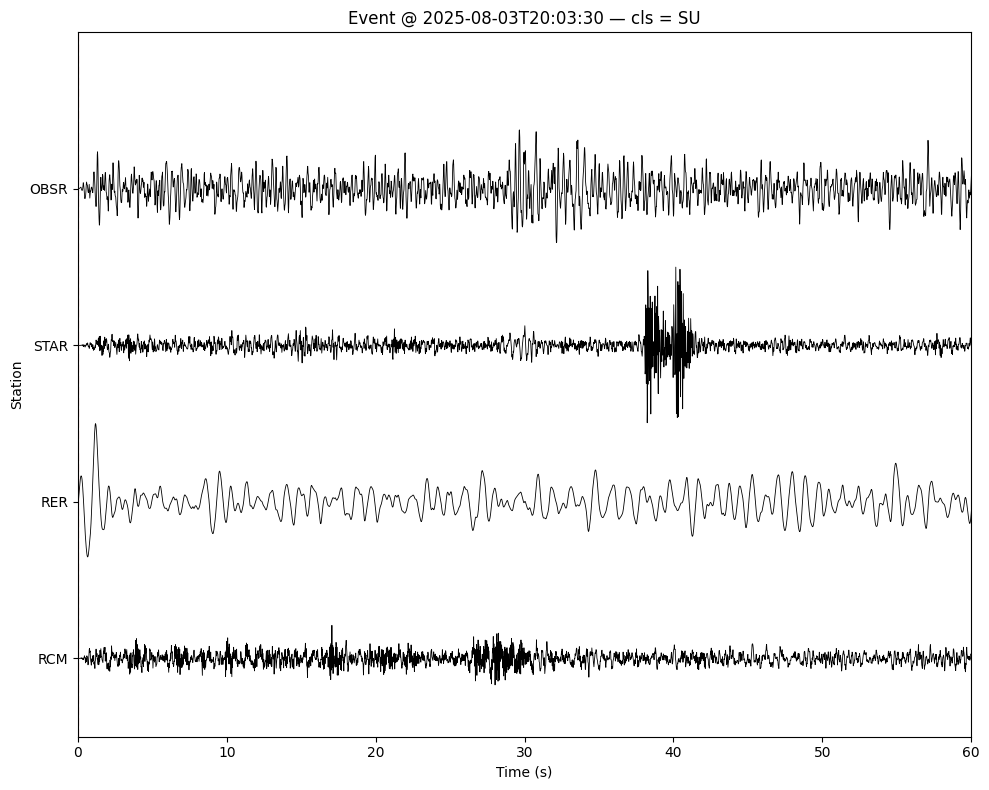

8 Trace(s) in Stream:
G.RER.00.QuakeXNet_eq | 2025-08-03T23:30:50.000000Z - 2025-08-03T23:30:50.000000Z | 0.1 Hz, 1 samples
G.RER.00.QuakeXNet_px | 2025-08-03T23:30:50.000000Z - 2025-08-03T23:30:50.000000Z | 0.1 Hz, 1 samples
G.RER.00.QuakeXNet_no | 2025-08-03T23:30:50.000000Z - 2025-08-03T23:30:50.000000Z | 0.1 Hz, 1 samples
G.RER.00.QuakeXNet_su | 2025-08-03T23:30:50.000000Z - 2025-08-03T23:30:50.000000Z | 0.1 Hz, 1 samples
UW.RER..QuakeXNet_eq  | 2025-08-03T23:30:50.000000Z - 2025-08-03T23:30:50.000000Z | 0.1 Hz, 1 samples
UW.RER..QuakeXNet_px  | 2025-08-03T23:30:50.000000Z - 2025-08-03T23:30:50.000000Z | 0.1 Hz, 1 samples
UW.RER..QuakeXNet_no  | 2025-08-03T23:30:50.000000Z - 2025-08-03T23:30:50.000000Z | 0.1 Hz, 1 samples
UW.RER..QuakeXNet_su  | 2025-08-03T23:30:50.000000Z - 2025-08-03T23:30:50.000000Z | 0.1 Hz, 1 samples
[0.04777952]
4 Trace(s) in Stream:
UW.STAR.01.QuakeXNet_eq | 2025-08-03T23:30:50.000000Z - 2025-08-03T23:30:50.000000Z | 0.1 Hz, 1 samples
UW.STAR.01.QuakeXNet_px

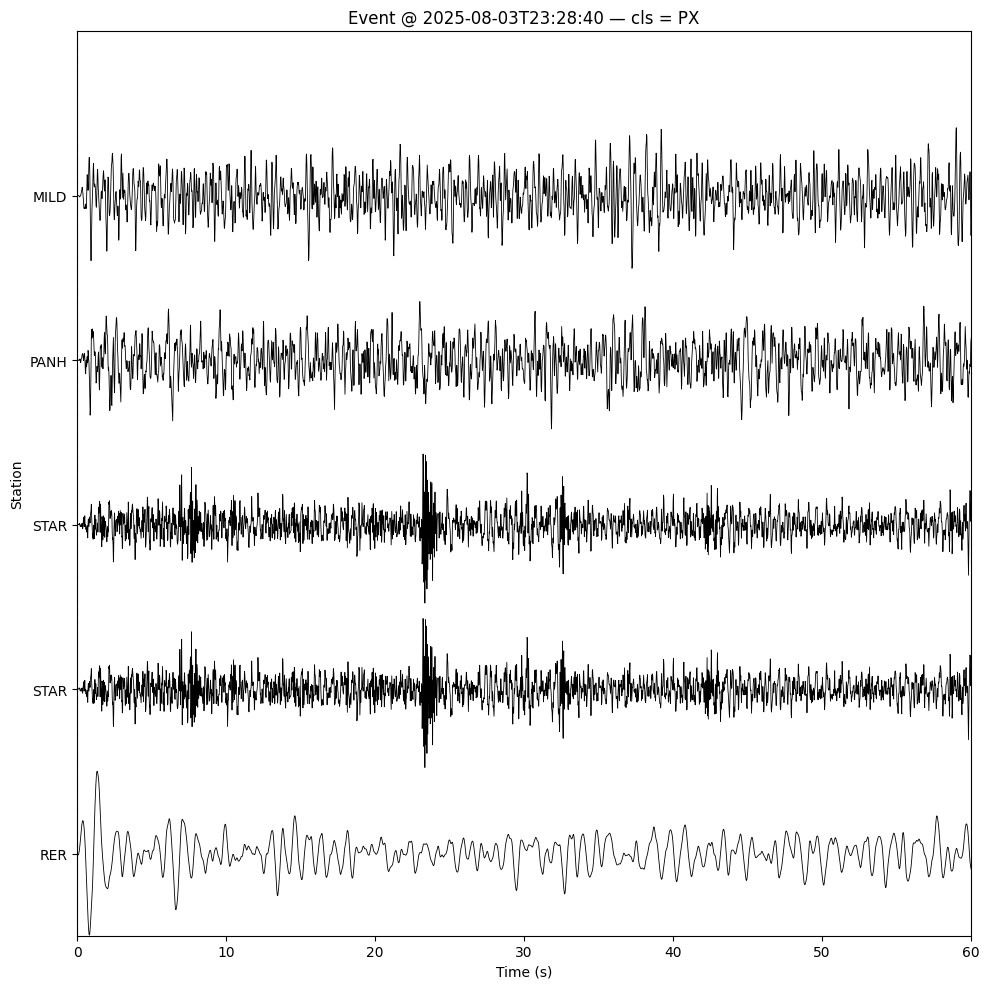

4 Trace(s) in Stream:
UW.RCM..QuakeXNet_eq | 2025-08-04T07:21:10.000000Z - 2025-08-04T07:21:10.000000Z | 0.1 Hz, 1 samples
UW.RCM..QuakeXNet_px | 2025-08-04T07:21:10.000000Z - 2025-08-04T07:21:10.000000Z | 0.1 Hz, 1 samples
UW.RCM..QuakeXNet_no | 2025-08-04T07:21:10.000000Z - 2025-08-04T07:21:10.000000Z | 0.1 Hz, 1 samples
UW.RCM..QuakeXNet_su | 2025-08-04T07:21:10.000000Z - 2025-08-04T07:21:10.000000Z | 0.1 Hz, 1 samples
[0.72994447]
4 Trace(s) in Stream:
CC.OBSR..QuakeXNet_eq | 2025-08-04T07:21:10.000000Z - 2025-08-04T07:21:10.000000Z | 0.1 Hz, 1 samples
CC.OBSR..QuakeXNet_px | 2025-08-04T07:21:10.000000Z - 2025-08-04T07:21:10.000000Z | 0.1 Hz, 1 samples
CC.OBSR..QuakeXNet_no | 2025-08-04T07:21:10.000000Z - 2025-08-04T07:21:10.000000Z | 0.1 Hz, 1 samples
CC.OBSR..QuakeXNet_su | 2025-08-04T07:21:10.000000Z - 2025-08-04T07:21:10.000000Z | 0.1 Hz, 1 samples
[0.63249594]
4 Trace(s) in Stream:
CC.PANH..QuakeXNet_eq | 2025-08-04T07:21:10.000000Z - 2025-08-04T07:21:10.000000Z | 0.1 Hz, 1 sa

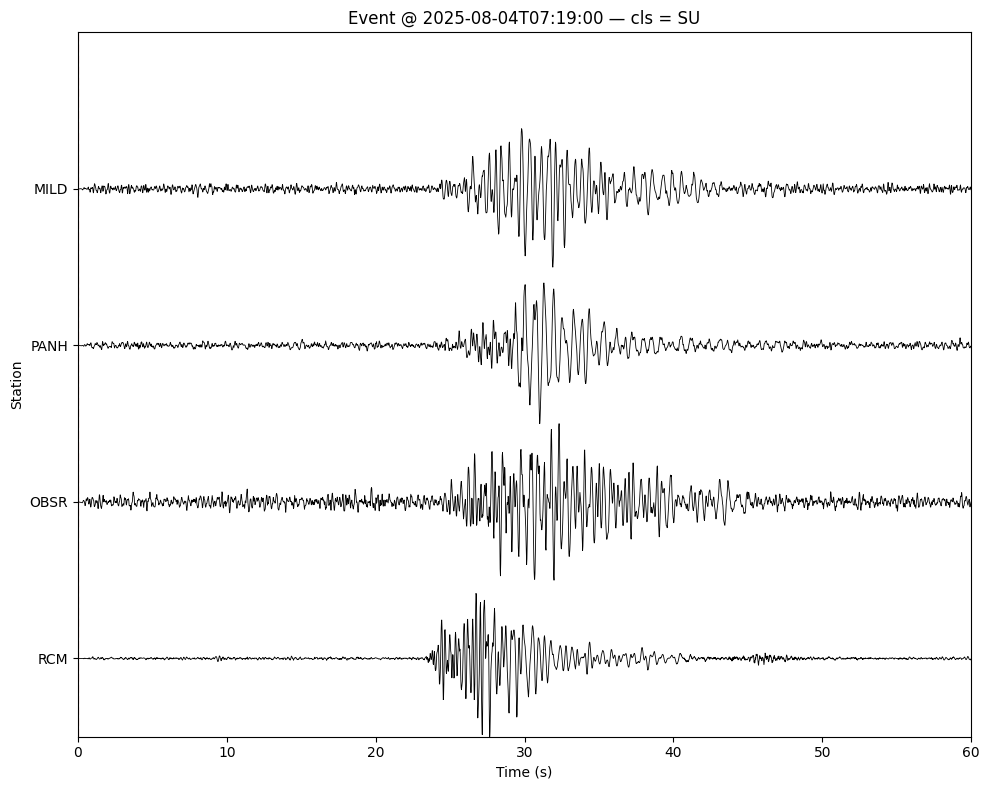

8 Trace(s) in Stream:
G.RER.00.QuakeXNet_eq | 2025-08-04T07:29:50.000000Z - 2025-08-04T07:29:50.000000Z | 0.1 Hz, 1 samples
G.RER.00.QuakeXNet_px | 2025-08-04T07:29:50.000000Z - 2025-08-04T07:29:50.000000Z | 0.1 Hz, 1 samples
G.RER.00.QuakeXNet_no | 2025-08-04T07:29:50.000000Z - 2025-08-04T07:29:50.000000Z | 0.1 Hz, 1 samples
G.RER.00.QuakeXNet_su | 2025-08-04T07:29:50.000000Z - 2025-08-04T07:29:50.000000Z | 0.1 Hz, 1 samples
UW.RER..QuakeXNet_eq  | 2025-08-04T07:29:50.000000Z - 2025-08-04T07:29:50.000000Z | 0.1 Hz, 1 samples
UW.RER..QuakeXNet_px  | 2025-08-04T07:29:50.000000Z - 2025-08-04T07:29:50.000000Z | 0.1 Hz, 1 samples
UW.RER..QuakeXNet_no  | 2025-08-04T07:29:50.000000Z - 2025-08-04T07:29:50.000000Z | 0.1 Hz, 1 samples
UW.RER..QuakeXNet_su  | 2025-08-04T07:29:50.000000Z - 2025-08-04T07:29:50.000000Z | 0.1 Hz, 1 samples
[0.3228087]
4 Trace(s) in Stream:
CC.OBSR..QuakeXNet_eq | 2025-08-04T07:29:50.000000Z - 2025-08-04T07:29:50.000000Z | 0.1 Hz, 1 samples
CC.OBSR..QuakeXNet_px | 20

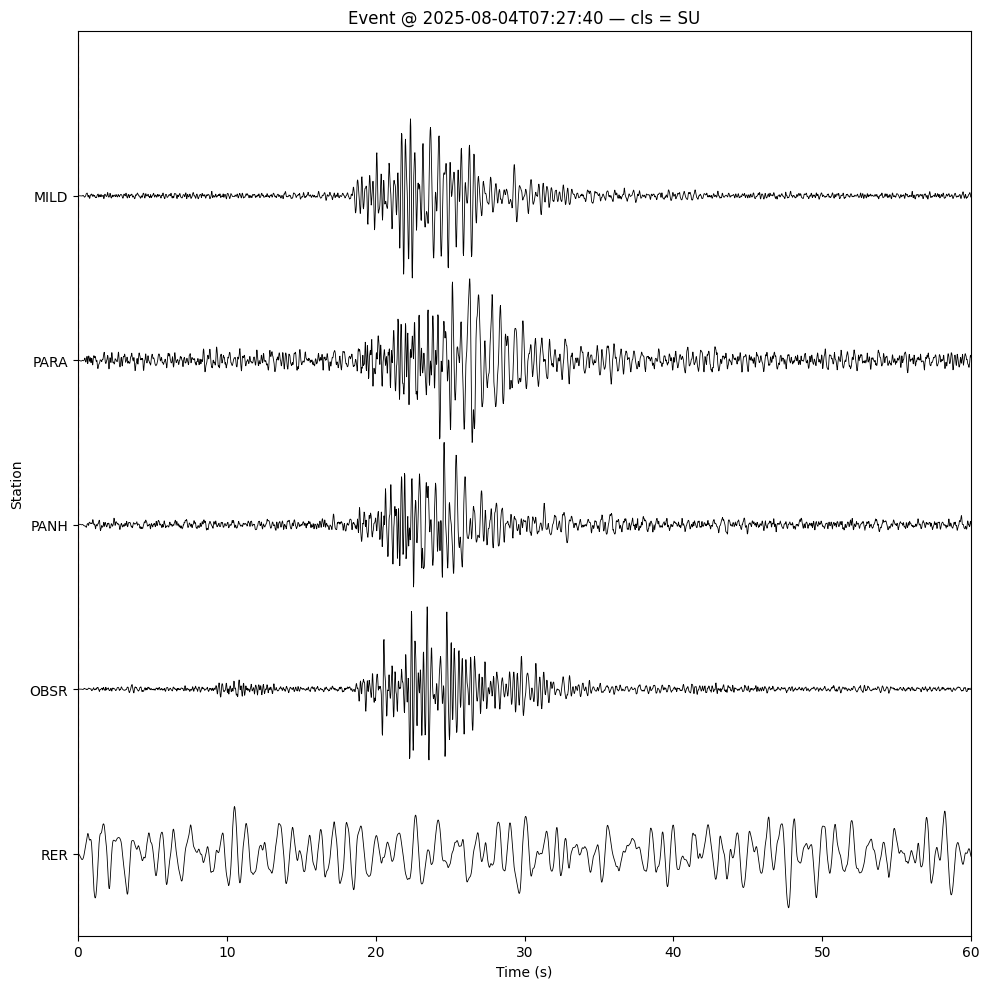

4 Trace(s) in Stream:
CC.OBSR..QuakeXNet_eq | 2025-08-04T07:44:30.000000Z - 2025-08-04T07:44:30.000000Z | 0.1 Hz, 1 samples
CC.OBSR..QuakeXNet_px | 2025-08-04T07:44:30.000000Z - 2025-08-04T07:44:30.000000Z | 0.1 Hz, 1 samples
CC.OBSR..QuakeXNet_no | 2025-08-04T07:44:30.000000Z - 2025-08-04T07:44:30.000000Z | 0.1 Hz, 1 samples
CC.OBSR..QuakeXNet_su | 2025-08-04T07:44:30.000000Z - 2025-08-04T07:44:30.000000Z | 0.1 Hz, 1 samples
[0.46694925]
4 Trace(s) in Stream:
CC.PANH..QuakeXNet_eq | 2025-08-04T07:44:30.000000Z - 2025-08-04T07:44:30.000000Z | 0.1 Hz, 1 samples
CC.PANH..QuakeXNet_px | 2025-08-04T07:44:30.000000Z - 2025-08-04T07:44:30.000000Z | 0.1 Hz, 1 samples
CC.PANH..QuakeXNet_no | 2025-08-04T07:44:30.000000Z - 2025-08-04T07:44:30.000000Z | 0.1 Hz, 1 samples
CC.PANH..QuakeXNet_su | 2025-08-04T07:44:30.000000Z - 2025-08-04T07:44:30.000000Z | 0.1 Hz, 1 samples
[0.16602153]
4 Trace(s) in Stream:
CC.PARA..QuakeXNet_eq | 2025-08-04T07:44:30.000000Z - 2025-08-04T07:44:30.000000Z | 0.1 Hz, 

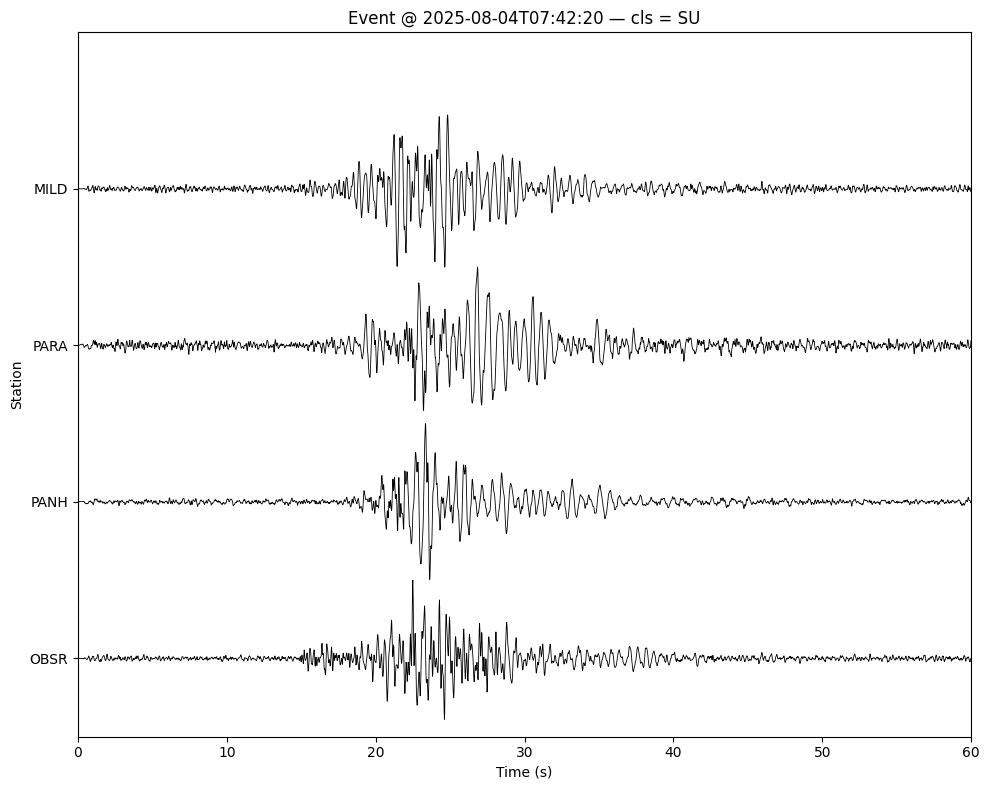

4 Trace(s) in Stream:
UW.RCM..QuakeXNet_eq | 2025-08-04T12:35:50.000000Z - 2025-08-04T12:35:50.000000Z | 0.1 Hz, 1 samples
UW.RCM..QuakeXNet_px | 2025-08-04T12:35:50.000000Z - 2025-08-04T12:35:50.000000Z | 0.1 Hz, 1 samples
UW.RCM..QuakeXNet_no | 2025-08-04T12:35:50.000000Z - 2025-08-04T12:35:50.000000Z | 0.1 Hz, 1 samples
UW.RCM..QuakeXNet_su | 2025-08-04T12:35:50.000000Z - 2025-08-04T12:35:50.000000Z | 0.1 Hz, 1 samples
[0.02715678]
8 Trace(s) in Stream:
G.RER.00.QuakeXNet_eq | 2025-08-04T12:35:50.000000Z - 2025-08-04T12:35:50.000000Z | 0.1 Hz, 1 samples
G.RER.00.QuakeXNet_px | 2025-08-04T12:35:50.000000Z - 2025-08-04T12:35:50.000000Z | 0.1 Hz, 1 samples
G.RER.00.QuakeXNet_no | 2025-08-04T12:35:50.000000Z - 2025-08-04T12:35:50.000000Z | 0.1 Hz, 1 samples
G.RER.00.QuakeXNet_su | 2025-08-04T12:35:50.000000Z - 2025-08-04T12:35:50.000000Z | 0.1 Hz, 1 samples
UW.RER..QuakeXNet_eq  | 2025-08-04T12:35:50.000000Z - 2025-08-04T12:35:50.000000Z | 0.1 Hz, 1 samples
UW.RER..QuakeXNet_px  | 2025-

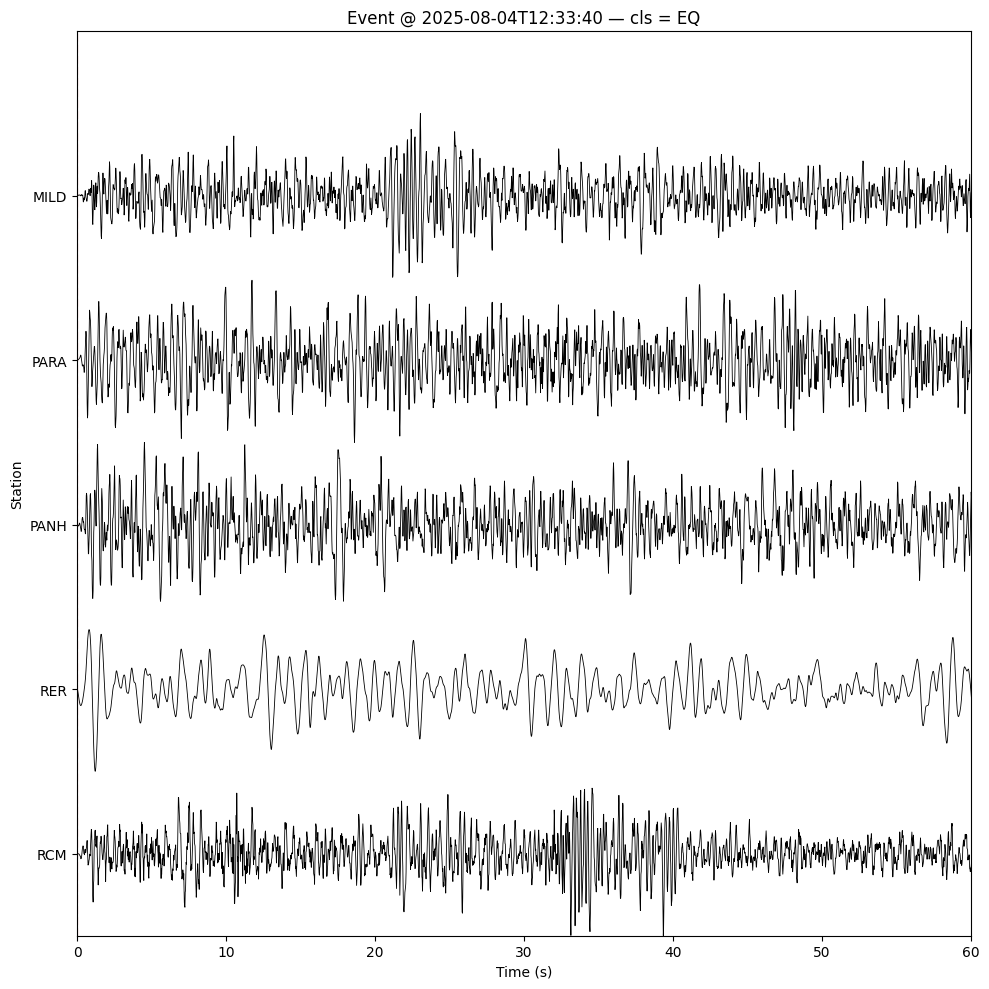

In [43]:
for i in range(len(common_events)):
    plot_event_waveforms(common_events.iloc[i], duration= 180)


# Visualizing the picks

## Loading various pretrained picking models

In [37]:
# Various pre-trained weights for PhaseNet
# pn_model = sbm.PhaseNet.from_pretrained("ethz")
# pn_model = sbm.PhaseNet.from_pretrained("instance")
# pn_model = sbm.PhaseNet.from_pretrained("scedc")
pn_model = sbm.PhaseNet.from_pretrained("stead")
# pn_model = sbm.PhaseNet.from_pretrained("geofon")
# pn_model = sbm.PhaseNet.from_pretrained("neic")

# Various pre-trained weights for EQT
eqt_model = sbm.EQTransformer.from_pretrained("original")
#eqt_model = sbm.EQTransformer.from_pretrained("ethz")
# eqt_model = sbm.EQTransformer.from_pretrained("instance")
#eqt_model = sbm.EQTransformer.from_pretrained("scedc")
# eqt_model = sbm.EQTransformer.from_pretrained("stead")
# eqt_model = sbm.EQTransformer.from_pretrained("geofon")

# Various pre-trained weights for GPD
# gpd_model = sbm.GPD.from_pretrained("original")
# gpd_model = sbm.GPD.from_pretrained("ethz")
# gpd_model = sbm.GPD.from_pretrained("scedc")
gpd_model = sbm.GPD.from_pretrained("stead")
# gpd_model = sbm.GPD.from_pretrained("geofon")
# gpd_model = sbm.GPD.from_pretrained("neic")

In [51]:
def plot_event_waveforms_and_picks(event_row, duration=300, peak_thresh=0.50, model = gpd_model):
    client      = Client("IRIS")
    event_time  = UTCDateTime(pd.to_datetime(event_row["rounded_start"]).to_pydatetime())
    stations    = ast.literal_eval(event_row["stations"])
    target_cls  = event_row["most_common_class"]

    fig, ax = plt.subplots(figsize=(10, 2 * len(stations)))

    y_offsets = []
    for i, sta in enumerate(stations):
        try:
            st = client.get_waveforms("*", sta, "*", "*HZ",
                                      starttime=event_time,
                                      endtime=event_time + duration)
            st.resample(50)
            

            # ── inference ───────────────────────────────────────────────
            probs_st = model.annotate(st)
            

        
            probs_tr_0 = probs_st[0]
            probs_tr_1 = probs_st[1]
            probs_tr_2 = probs_st[2]
            
            t_probs  = probs_tr_0.times() 
            
            
            d_probs_0  = probs_tr_0.data*2
            d_probs_1 = probs_tr_1.data*2
            d_probs_2 = probs_tr_2.data*2

            # ── waveform prep ───────────────────────────────────────────
            st.detrend("linear"); st.taper(0.01)
            st.filter("bandpass", freqmin=1, freqmax=20)
            tr       = st[0]
            t_wave   = tr.times("relative")
            y_wave   = tr.data / np.abs(tr.data).max()

            # ── plot ────────────────────────────────────────────────────
            offset = 2 * i
            y_offsets.append(offset)
            ax.plot(t_wave,  y_wave + offset,  lw=0.6, color="black")
            
            
            t_max = t_wave[np.argmax(y_wave+offset)]
         
            ax.plot(t_probs, d_probs_0 + offset, lw=1.2, color = 'orange')
            ax.plot(t_probs, d_probs_1 + offset, lw=1.2, color = 'blue')
            ax.plot(t_probs, d_probs_2 + offset, lw=1.2, color = 'green')

            # annotate peaks above threshold
            """
            peaks = np.where((d_probs[1:-1] > d_probs[:-2]) &
                             (d_probs[1:-1] > d_probs[2:]) &
                             (d_probs[1:-1] >= peak_thresh))[0] + 1
            for p in peaks:
                ax.text(t_probs[p], d_probs[p] + offset + 0.05,
                        f"{d_probs[p]:.2f}", ha="center", va="bottom",
                        fontsize=7, color="darkblue")
            """
        except Exception as e:
            print(f"❌ {sta}: {e}")

    # ── styling ────────────────────────────────────────────────────────
    ax.axvline(0, color="red", ls="--")
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Event @ {event_time.isoformat()} — cls = {target_cls.upper()}")

    # put station names on y-axis at the row centers
    ax.set_yticks(y_offsets)
    ax.set_yticklabels(stations)
    ax.set_ylabel("Station")

    ax.set_xlim( t_max - 50, t_max + 50)
    ax.set_ylim(-1, 2 * len(stations))
    plt.tight_layout()
    plt.show()


/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


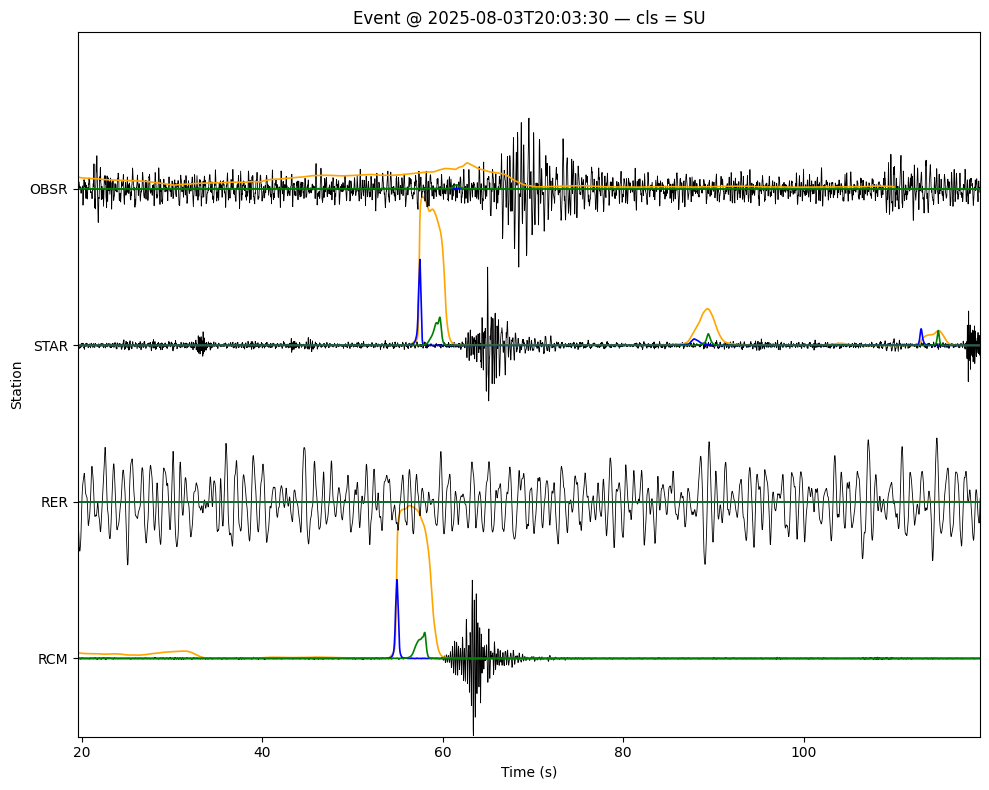

/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/

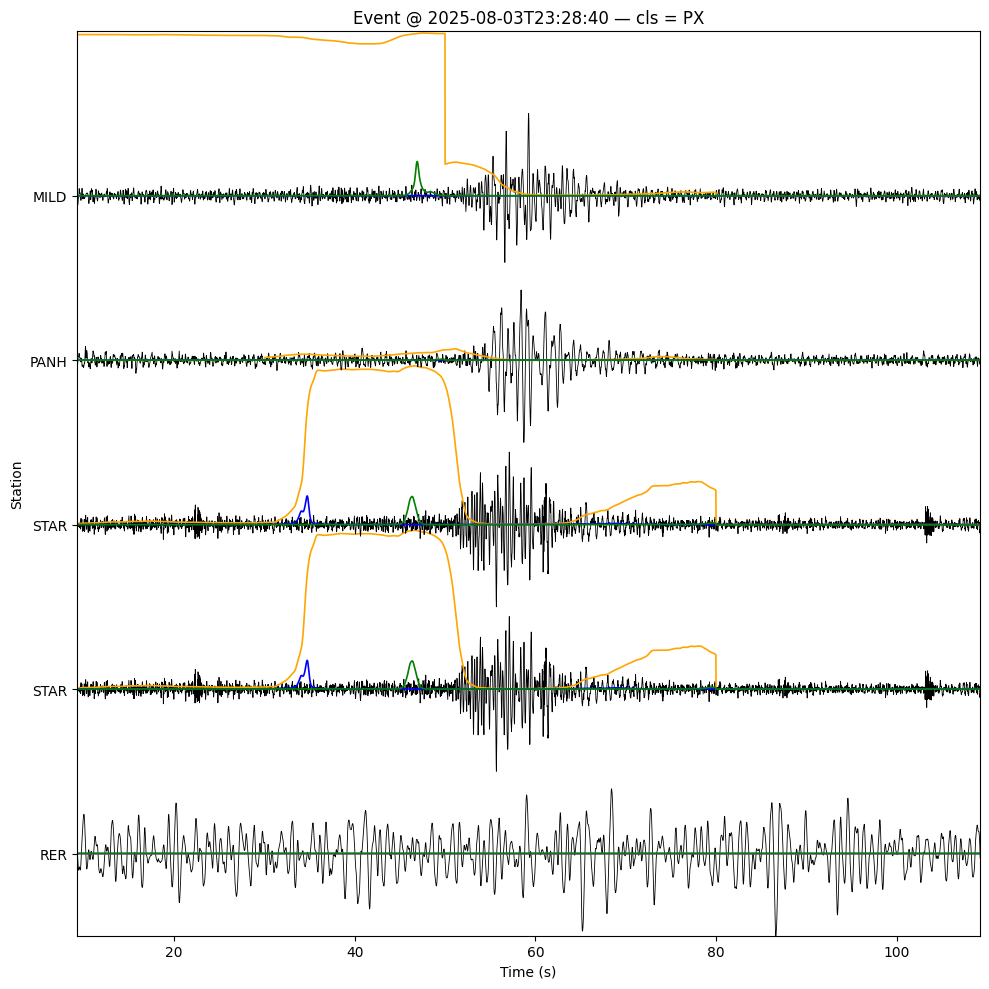

/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


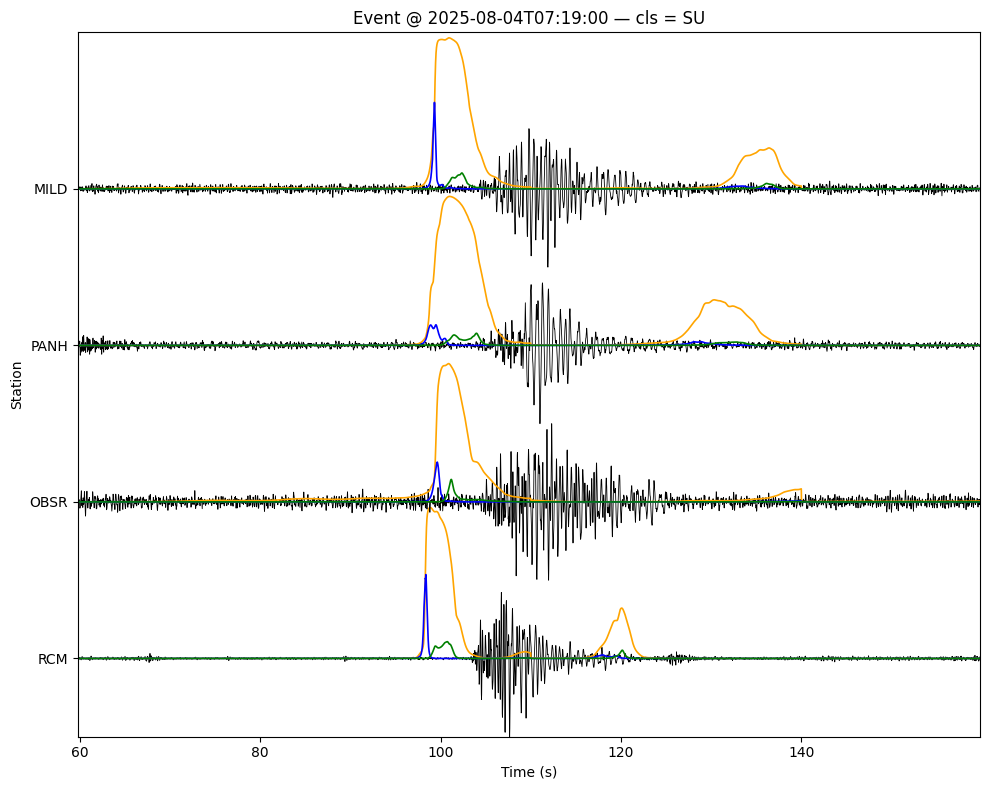

/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/

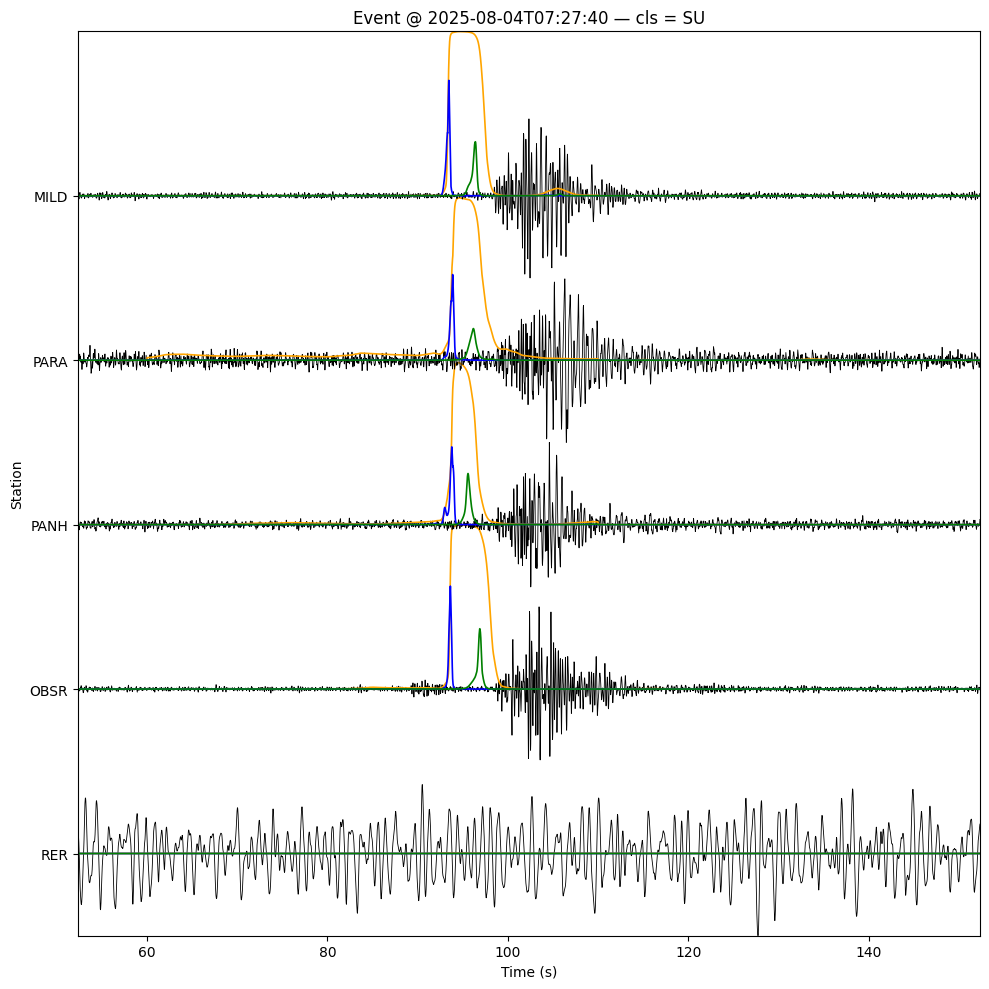

/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


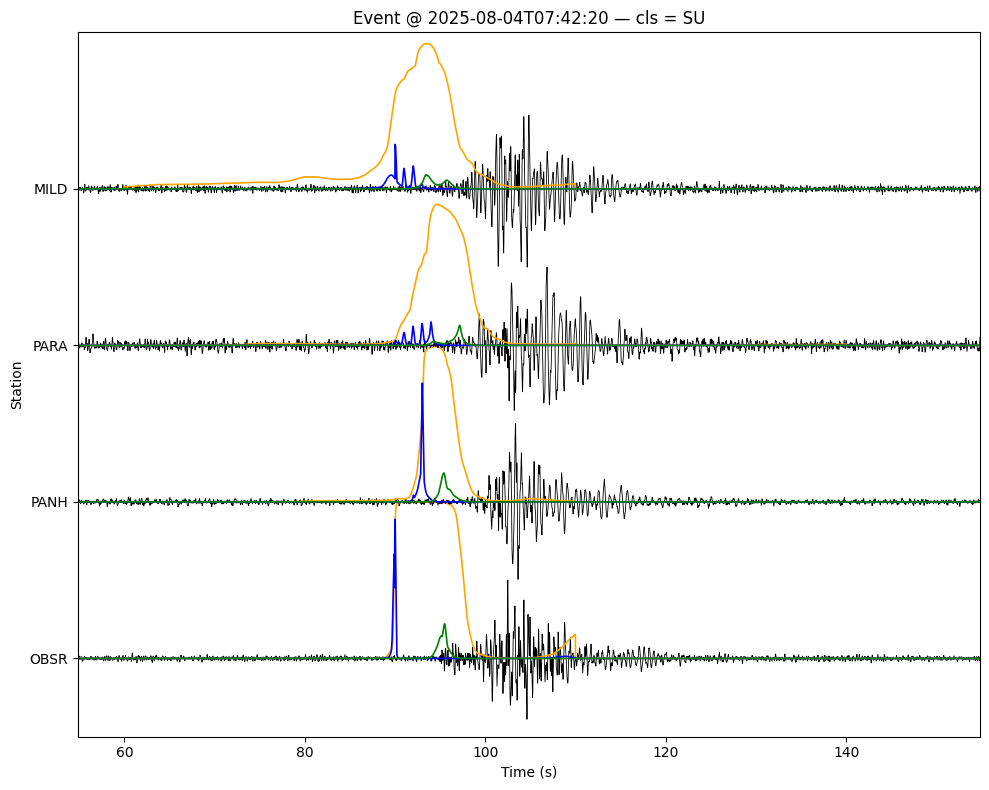

/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/

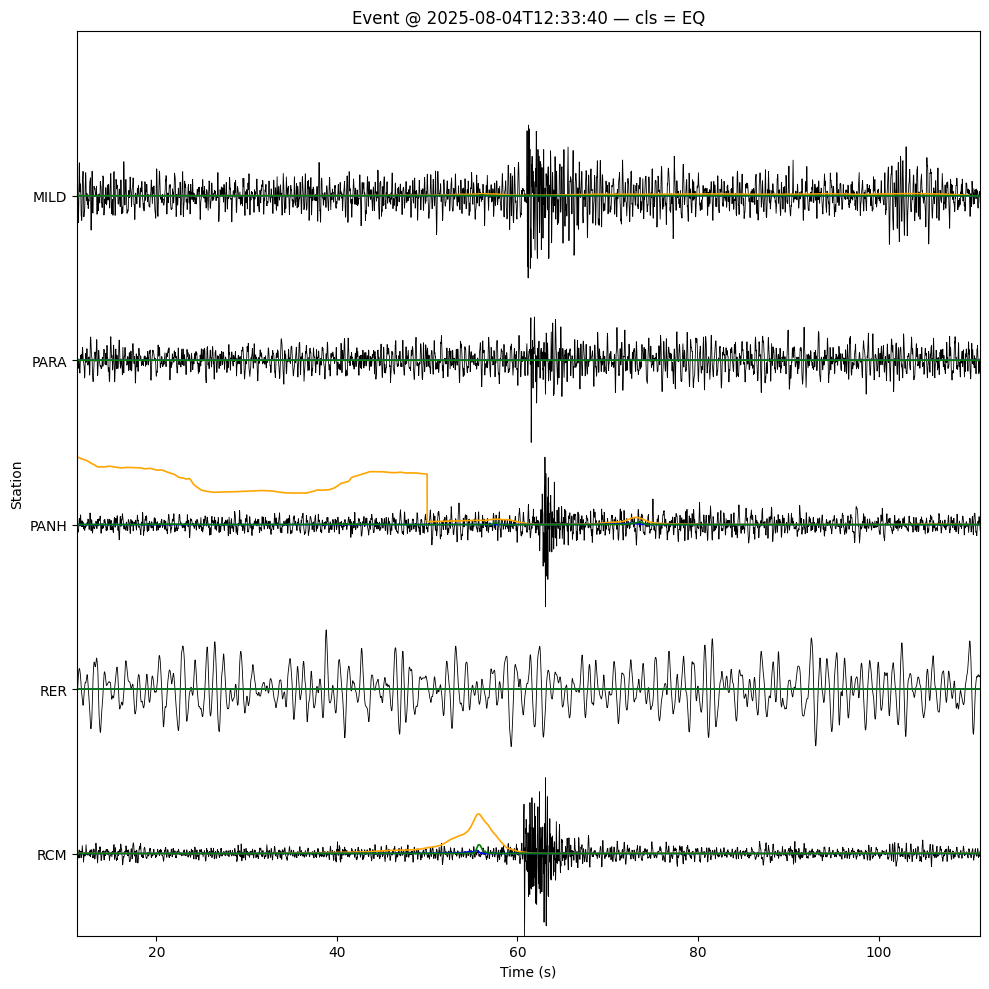

In [52]:
for i in range(len(common_events)):
    plot_event_waveforms_and_picks(common_events.iloc[i], duration= 180, model = eqt_model)

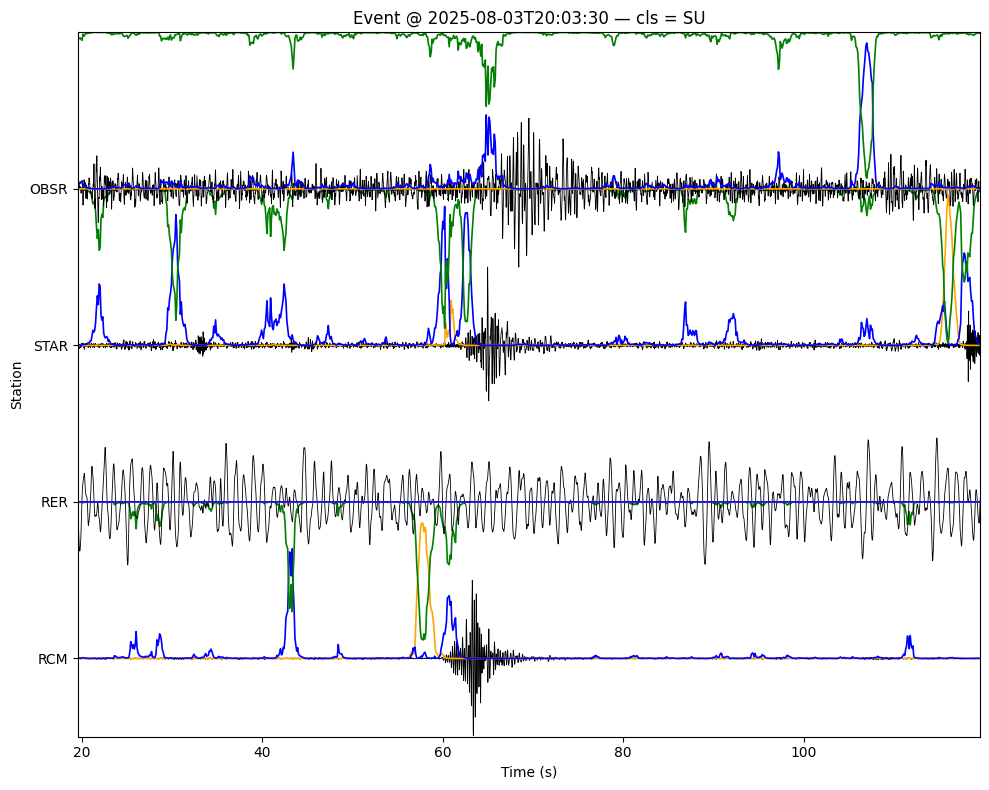

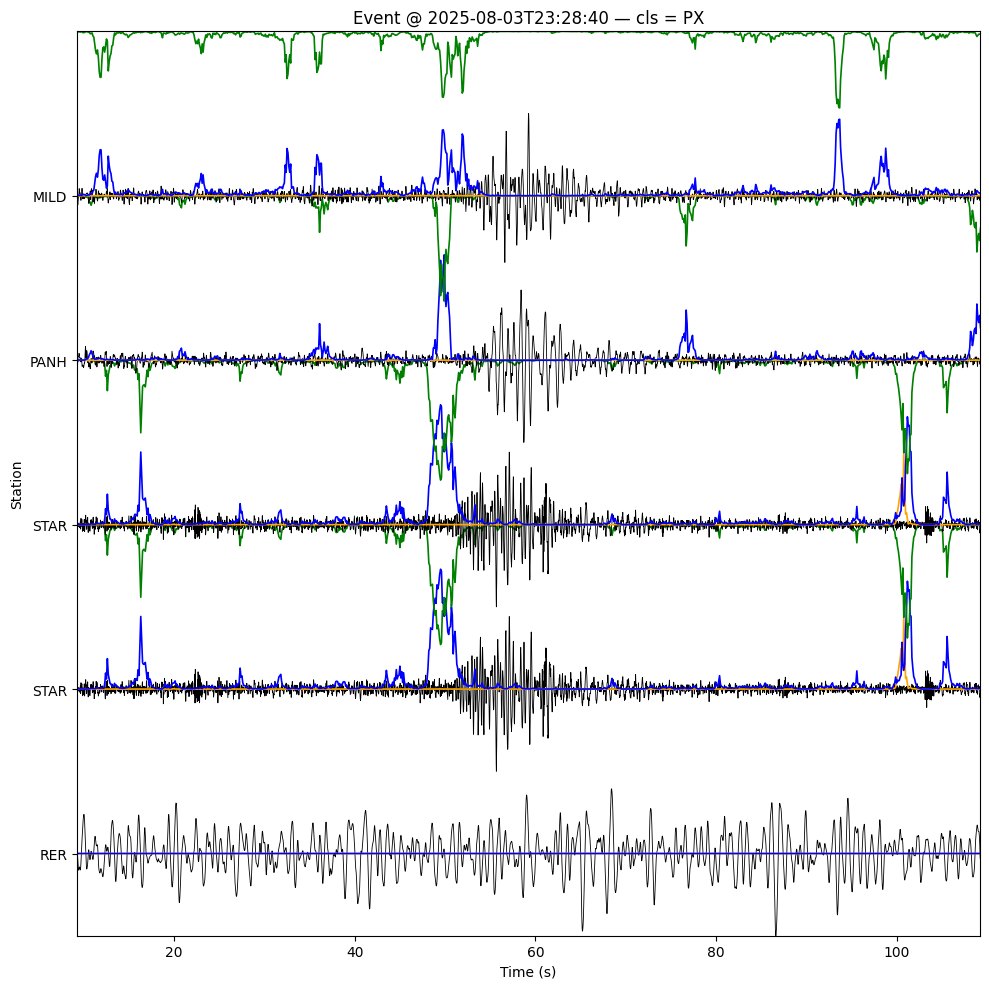

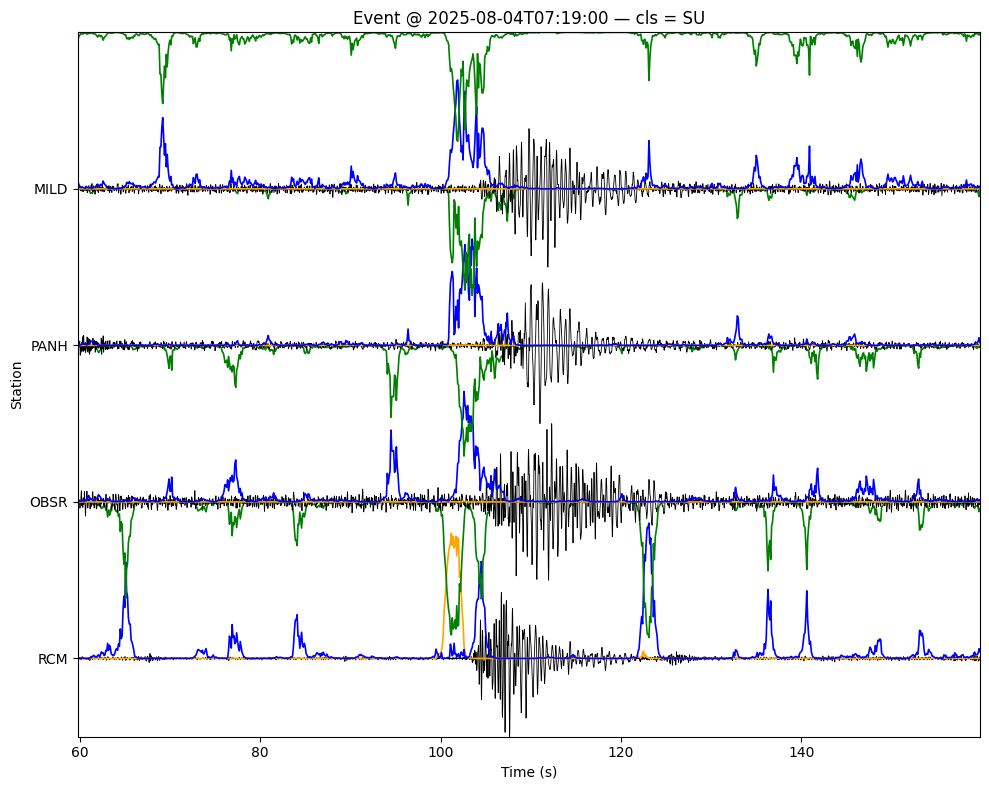

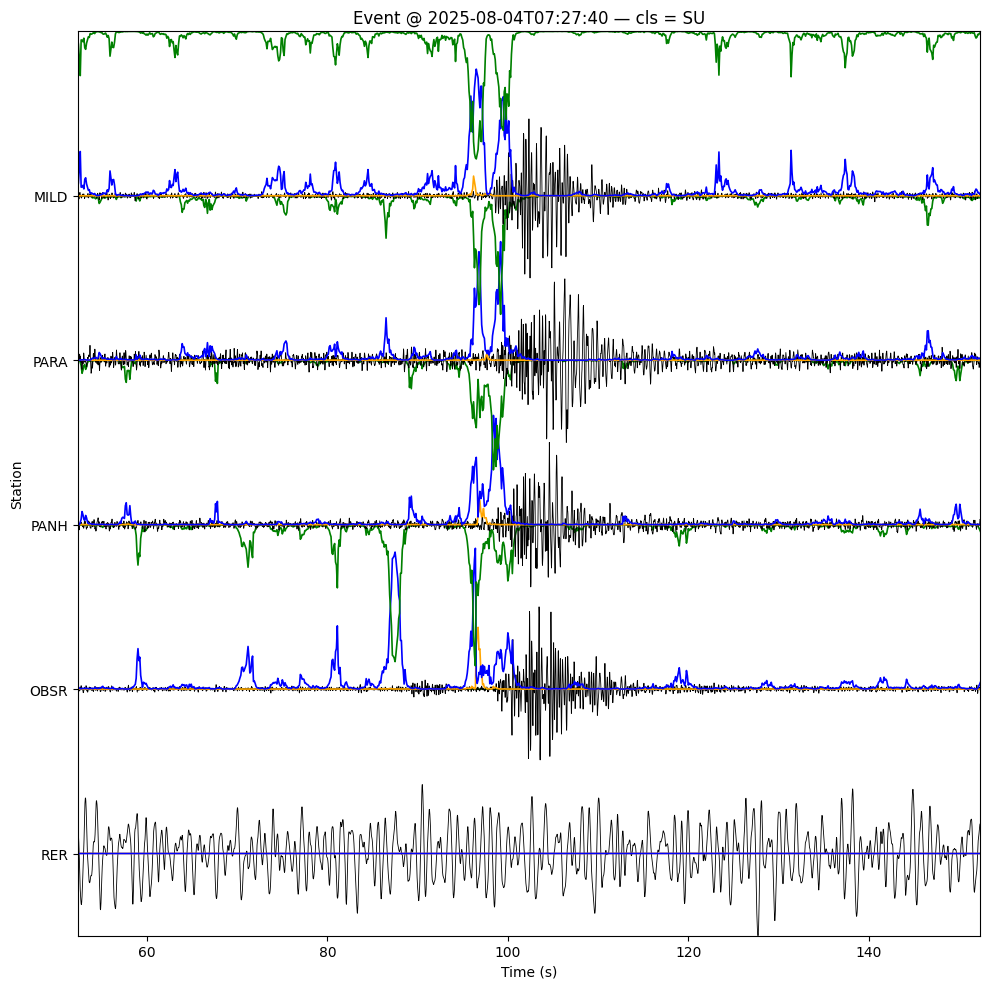

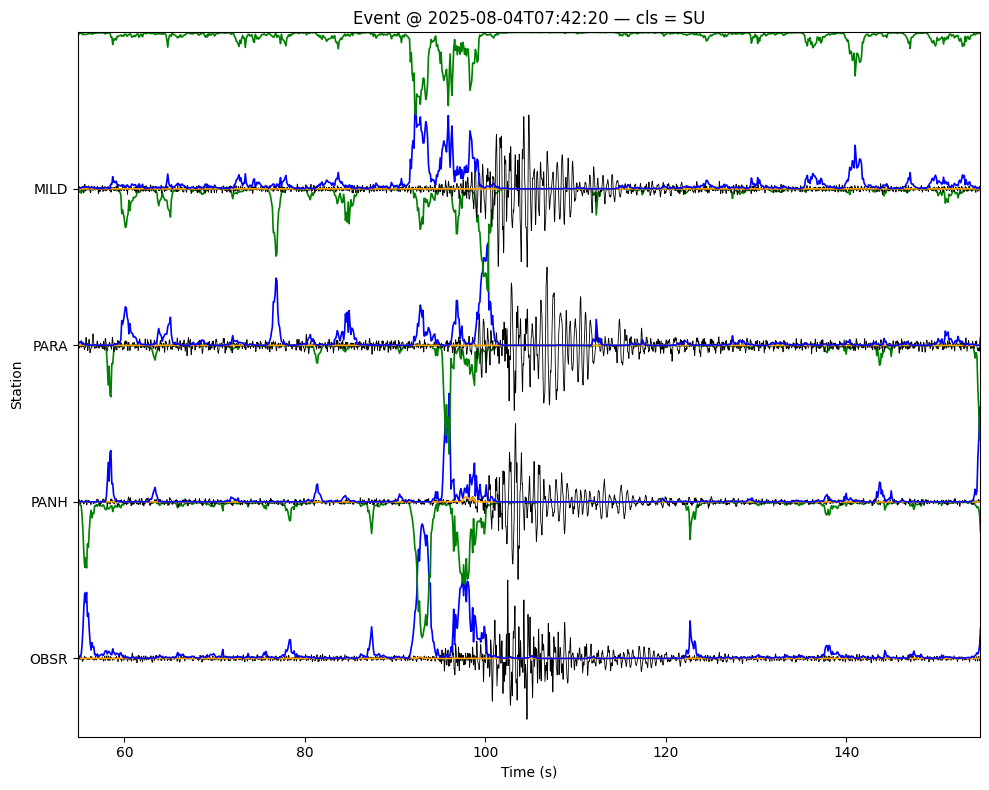

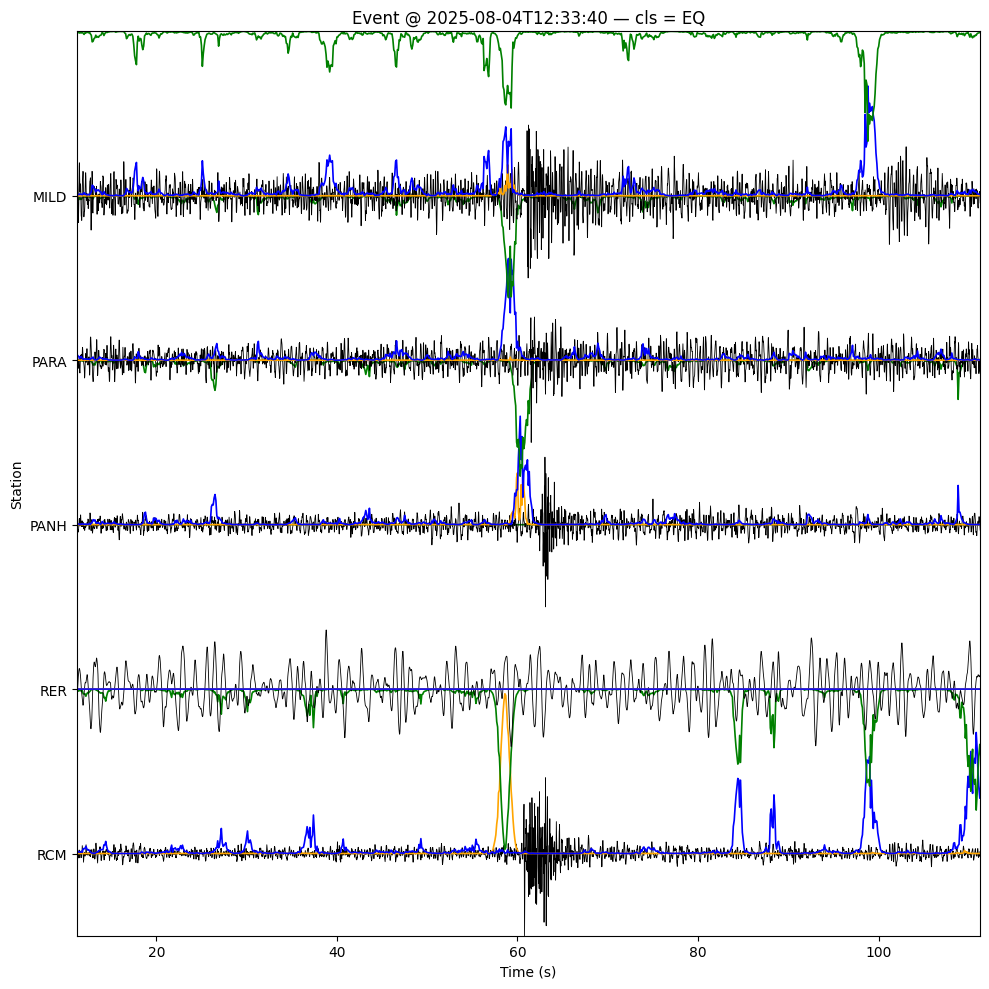

In [53]:
for i in range(len(common_events)):
    plot_event_waveforms_and_picks(common_events.iloc[i], duration= 180, model = gpd_model)


In [213]:
pn_model.cuda();
eqt_model.cuda();
gpd_model.cuda();

In [ ]:


client = Client("IRIS")
event_time  = UTCDateTime(event_row["rounded_start"])
stream = client.get_waveforms(network="CC", station="PANH", location="*", channel="*H?", 
                              starttime= event_time, 
                              endtime=t+300)


fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend();